# ViT model for ML Use Case 2

In this notebook, we delve into the road damage assessment dataset. Our goal is to train a model for damage severity classification. Specifically, we will set up data paths, load the dataset, and preprocess the data for training. We will then train the ViT model and evaluate its performance using metrics like classification reports and confusion metrics. Finally, we will visualize sample predictions to understand the model's performance better. 

In [1]:
# import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import pandas as pd
import numpy as np
import timm
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage, Compose, Normalize
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### 1. Set Up Data Paths

In [3]:
# Define the paths to the train and test dataset csv files
train_csv_path = "../damage_assessment/train_Dataset_Info.csv"
test_csv_path = "../damage_assessment/test_Dataset_Info.csv"

# Load the train and test dataset from the csv files
train_data = pd.read_csv(train_csv_path)
test_data = pd.read_csv(test_csv_path)

### 2. Load and preprocess the data

In [4]:
# Define a sequence of transformations to be applied to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize the images to 224*224 pixels
    transforms.ToTensor(), # Convert the images to Pytorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize the images using mean and std deviation for each channel
])

In [5]:
# Define a custom dataset class for road damage data
class RoadDamageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['Image_Path'] # Get the image path
        image = Image.open(img_path).convert("RGB") # Open the image and convert to RGB
        label = self.dataframe.iloc[idx]['Severity_Level'] # Get the severity level label
        meta = self.dataframe.iloc[idx]['Number of Potholes'] # Get the number of potholes
        
        if self.transform:
            image = self.transform(image) # Apply the transform to the image
        
        return image, torch.tensor(meta, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [6]:
# Create dataset instances for training and testing data
train_dataset = RoadDamageDataset(train_data, transform=transform)
test_dataset = RoadDamageDataset(test_data, transform=transform)

# Create data loaders for training and testing data
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

### 3. Define the model

In [7]:
# Define the device to be used for training (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
# Define the ViT model
class ViTModel(nn.Module):
    def __init__(self):
        super(ViTModel, self).__init__()
        # Load a pre-trained Vision Transformer (ViT) model from the timm library
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True)
        # Replace the head of the ViT model with a Linear layer for feature extraction
        self.vit.head = nn.Linear(self.vit.head.in_features, 512)
        # Define a fully connected layer to combine image features with meta data
        self.fc1 = nn.Linear(512 + 1, 256)
        # Define the output layer for classifying severity levels (4 classes)
        self.fc2 = nn.Linear(256, 4)
        # Define a ReLU activation function
        self.relu = nn.ReLU()
        # Define a dropout layer for regularization
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, image, meta):
        # Forward pass through the ViT model to extract image features
        x = self.vit(image)
        # Concatenate the image features with the meta data
        x = torch.cat((x, meta.unsqueeze(1)), dim=1)
        # Forward pass through the fully connected layer with ReLU activation and dropout
        x = self.dropout(self.relu(self.fc1(x)))
        # Forward pass through the output layer to get the class scores
        x = self.fc2(x)
        return x

In [9]:
# Instantiate the model, loss function, and optimizer
vit_model = ViTModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_model.parameters(), lr=0.0001)

### 4. Train the model

In [27]:
# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    vit_model.train() # Set the model to training mode
    running_loss = 0.0
    print(f"Epoch [{epoch+1}/{num_epochs}] starting...") # Debug information
    
    for i, (images, metas, labels) in enumerate(train_loader):
        images, metas, labels = images.to(device), metas.to(device), labels.to(device)
        optimizer.zero_grad() # Zero the gradients
        outputs = vit_model(images, metas) # Forward pass
        loss = criterion(outputs, labels) # Compute the loss
        loss.backward() # Backward pass
        optimizer.step() # Update the weights
        
        running_loss += loss.item()
        if i % 10 == 9:
            print(f"[{epoch+1}, {i+1}] loss: {running_loss / (i+1)}")
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

    # Validation loss check
    vit_model.eval() # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, metas, labels in test_loader:
            images, metas, labels = images.to(device), metas.to(device), labels.to(device)
            outputs = vit_model(images, metas)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(test_loader)
    val_acc = 100 * correct / total
    print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}%")
    
    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = vit_model.state_dict()
        torch.save(best_model_wts, 'best_vit_model.pth')

print("Finished Training")

Epoch [1/50] starting...


c:\Users\flag8\.venv\pytorch-gpu\lib\site-packages\timm\models\vision_transformer.py:92: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  x = F.scaled_dot_product_attention(


[1, 10] loss: 1.1812615156173707
[1, 20] loss: 1.0827392220497132
[1, 30] loss: 1.0504625538984935
[1, 40] loss: 1.0202343925833701
[1, 50] loss: 0.9938846147060394
[1, 60] loss: 0.9646241058905919
[1, 70] loss: 0.949360933474132
[1, 80] loss: 0.9257414326071739
[1, 90] loss: 0.9129225379890866
[1, 100] loss: 0.9068541687726974
[1, 110] loss: 0.9008447267792442
[1, 120] loss: 0.8909611483414968
[1, 130] loss: 0.8798798377697284
[1, 140] loss: 0.8706474930047989
[1, 150] loss: 0.8600995024045308
[1, 160] loss: 0.8591977223753929
[1, 170] loss: 0.8530345972846536
[1, 180] loss: 0.8492913550800747
[1, 190] loss: 0.8454295086233239
[1, 200] loss: 0.8403066059947014
[1, 210] loss: 0.8361094026338487
[1, 220] loss: 0.8282172266732563
[1, 230] loss: 0.8247204216925994
[1, 240] loss: 0.8185049078116814
Epoch [1/50], Loss: 0.815748607159638
Validation Accuracy: 71.28916281458655%
Epoch [2/50] starting...
[2, 10] loss: 0.6067429691553116
[2, 20] loss: 0.6282090827822685
[2, 30] loss: 0.636719082

KeyboardInterrupt: 

### 5. Model Evaluation

Accuracy: 75.19%
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       600
           1       0.52      0.53      0.52       251
           2       0.58      0.40      0.47       374
           3       0.81      0.90      0.86       722

    accuracy                           0.75      1947
   macro avg       0.69      0.68      0.68      1947
weighted avg       0.74      0.75      0.74      1947

Confusion Matrix:


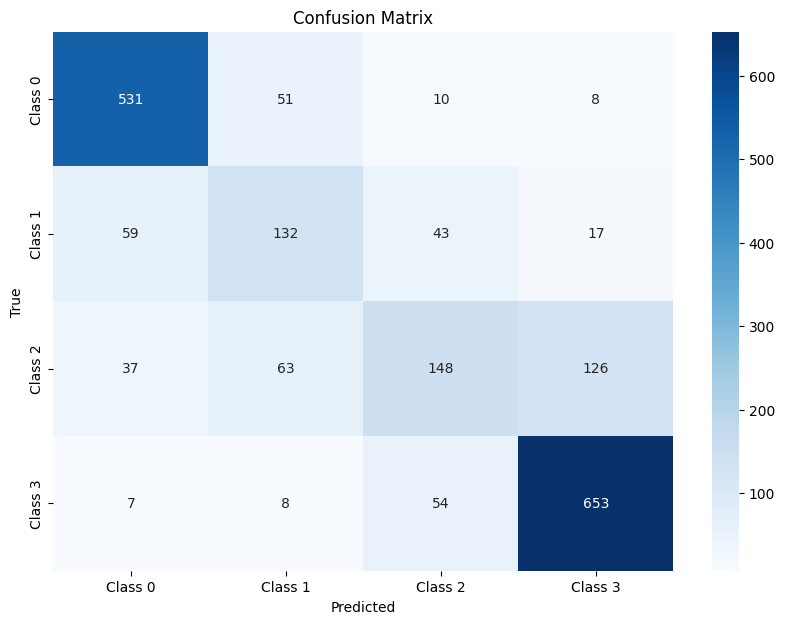

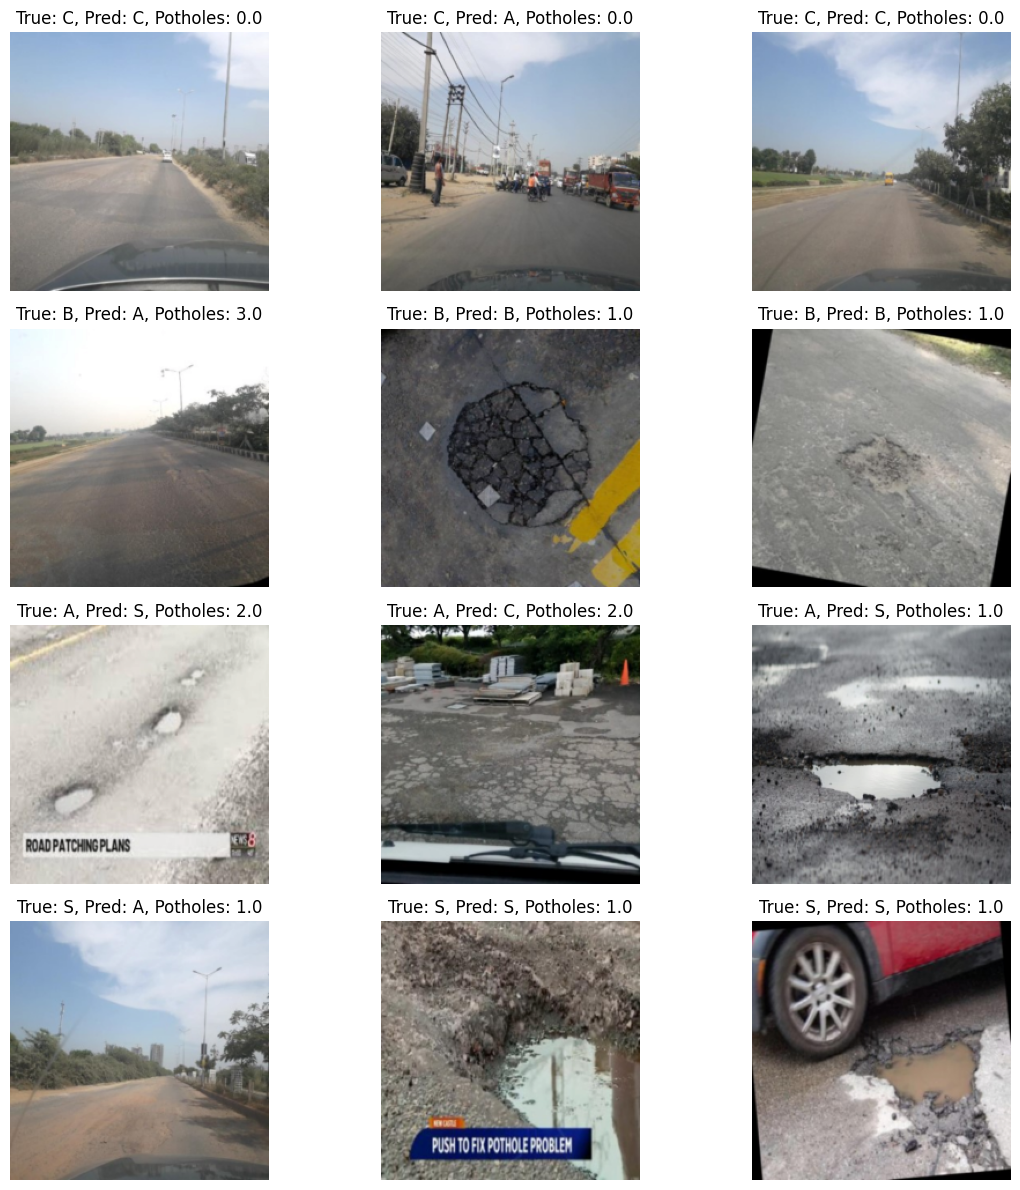

In [11]:
# Load the saved model
vit_model.load_state_dict(torch.load('best_vit_model.pth', map_location=device))
vit_model.eval()

# Initialize lists to store labels and predictions
all_preds = []
all_labels = []

# Evaluate the model
with torch.no_grad():
    for images, metas, labels in test_loader:
        images, metas, labels = images.to(device), metas.to(device), labels.to(device)
        outputs = vit_model(images, metas)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate the classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds))

# Plot the confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Class {i}' for i in range(cm.shape[0])], yticklabels=[f'Class {i}' for i in range(cm.shape[0])])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Define inverse normalization
inv_normalize = Compose([
    Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
    Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.])
])
# Display two sample images for each label
label_names = ['C', 'B', 'A', 'S']
label_indices = [0, 1, 2, 3]
samples_per_label = 3

# Initialize a dictionary to store sample counts for each label
sample_counts = {label: 0 for label in label_indices}

# Initialize a figure for plotting
fig, axes = plt.subplots(len(label_indices), samples_per_label, figsize=(12, 12))

# Set the model to evaluation mode
vit_model.eval()

# Iterate through the test data
with torch.no_grad():
    sample_plotted = {label: 0 for label in label_indices}
    for images, metas, labels in test_loader:
        if all(count == samples_per_label for count in sample_plotted.values()):
            break
        images, metas, labels = images.to(device), metas.to(device), labels.to(device)
        outputs = vit_model(images, metas)
        _, preds = torch.max(outputs, 1)
        
        for j in range(len(images)):
            true_label = labels[j].item()
            if sample_plotted[true_label] < samples_per_label:
                ax = axes[true_label, sample_plotted[true_label]]
                image = inv_normalize(images[j].cpu())
                image = ToPILImage()(image)
                ax.imshow(image)
                ax.set_title(f"True: {label_names[true_label]}, Pred: {label_names[preds[j].item()]}, Potholes: {metas[j].item()}")
                ax.axis('off')
                sample_plotted[true_label] += 1

# Adjust layout
plt.tight_layout()
plt.show()